## Описание задания

Наш клиент (продуктовая сеть) хочет прогнозировать входящий трафик на месяц вперед с детализацией по часу. Мы запросили исторические данные за полтора года и клиент их прислал. 
#### В рамках задания необходимо:

1. сделать мини анализ данных
2. предложить вариант, как сделать прогноз количества входящих
3. выбрать метрику для оценки качества
4. Необязательное: спрогнозировать количество входящих на декабрь 2019 года 

**Основная цель задания** -- продемонстрировать навыки обработки информации / знание методов прогнозирования, умение оформлять ноутбуки. Второстепенная задача это точность прогноза.

#### Требования к заданию:
1. результат присылать в виде zip архива с 3 документами: ipynb-ноутбук с кодом, его же в html и прогноз на декабрь 2019 (если пункт 4 выполняете).
2. прислать на почту a.aleskin@mindandmachine.ru c названием: Тестовое задание DS 202008
3. Выполнить задание необходимо в течение 48 часов после выдачи. Ожидаемое время на выполнение 2-4 часа (для 4ого опционального пункта ожидается, что кандидат выберет легко "управляемый" метод прогнозирования машинного обучения, иначе все займет намного больше времени).

#### Данные в архиве:
1. train.xlsx
2. test.xlsx


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

Читаем таблицу, удаляем ненужную колонку, устанавливаем дату как индекс

In [2]:
df_name = 'train.xlsx'
# df_name = 'test.xlsx'
df = pd.read_excel(df_name).drop(columns='Unnamed: 0').rename(columns={'dt_h_open': 'Date'})
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

В таблице данные по 2 магазинам

In [3]:
market_key = 'Номер магазина'
market1_name, market2_name = df[market_key].unique()
print(market1_name, market2_name)

Алтушка Бутово


In [4]:
df.head(2)

,Номер магазина,Количество вошедших,weekday,day,month,year,hour,weekday_number_in_month
Date,,,,,,,,
2018-03-01 08:00:00,Алтушка,5,3,1,3,2018,8,0
2018-03-01 08:00:00,Бутово,63,3,1,3,2018,8,0


In [5]:
df.tail(2)

,Номер магазина,Количество вошедших,weekday,day,month,year,hour,weekday_number_in_month
Date,,,,,,,,
2019-11-30 21:00:00,Алтушка,65,5,30,11,2019,21,4
2019-11-30 22:00:00,Бутово,3,5,30,11,2019,22,4


Разделим таблицу по магазинам

In [6]:
market1_df = df.loc[df[market_key] == market1_name]
market2_df = df.loc[df[market_key] == market2_name]

Посмотрим, есть ли линейная связь между трафиком и другими колонками. Видим, что самая сильная связь с часами, чуть меньше день недели, а остальные уже незначительные.

In [7]:
market1_df.corr().iloc[0]

Количество вошедших        1.000000
weekday                    0.118060
day                        0.013147
month                      0.010827
year                       0.006374
hour                       0.262257
weekday_number_in_month    0.009329
Name: Количество вошедших, dtype: float64

In [8]:
market2_df.corr().iloc[0]

Количество вошедших        1.000000
weekday                   -0.085902
day                        0.004476
month                     -0.017177
year                      -0.060738
hour                       0.121283
weekday_number_in_month    0.000045
Name: Количество вошедших, dtype: float64

In [9]:
traffic_key = 'Количество вошедших'

def plot_resampling(df1, df2, resample_rule):
    df1, df2 = df1.resample(resample_rule).mean(), df2.resample(resample_rule).mean()
    plt.figure(figsize=(10, 8))
    plt.plot(df1[traffic_key], 'b-', label=market1_name)
    plt.plot(df2[traffic_key], 'r-', label=market2_name)
    plt.xlabel('Date'); plt.ylabel(traffic_key); plt.title(traffic_key)
    plt.legend();
    

Отрисуем трафик, усреднённый по дням для двух магазинов. Видим, что трафик во втором магазине почти всегда ниже. График в первом магазине периодический c периодом в 12 месяцев, с пиком в июле. По второму магазину пропущены данны по двум областям

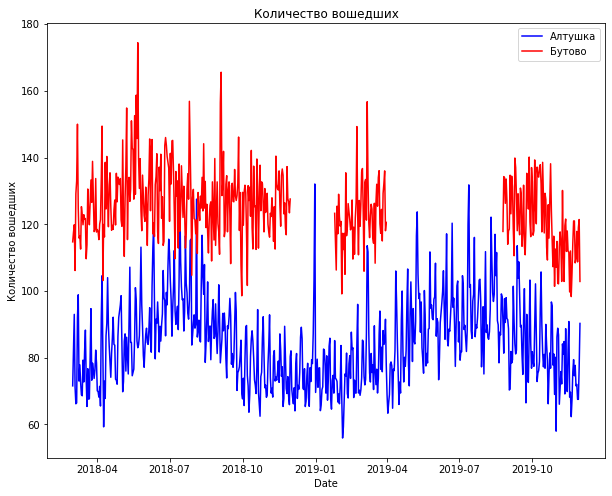

In [10]:
plot_resampling(market1_df, market2_df, 'D')

На локальном уровне видно, что есть период в 7-8 дней

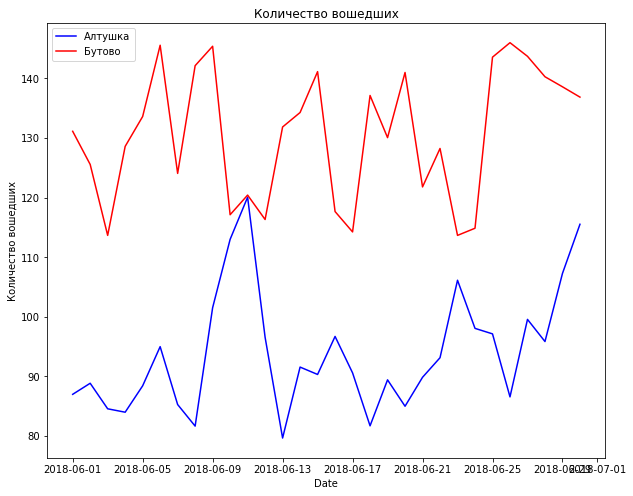

In [11]:
sl = slice('2018-06','2018-06')
plot_resampling(market1_df[sl], market2_df[sl], 'D')

In [12]:
weekday_names = 'sun mon tue wed thu fri sat'.split()
def plot_weekday_means(df1):
    plt.figure(figsize=(20, 10))
    colors = plt.cm.jet(np.random.choice(np.linspace(0, 1, 14), 8, replace=False))
    for weekday, weekday_name in enumerate(weekday_names):
        plot_df = df1.loc[df1['weekday'] == weekday].resample('M').mean()
        plt.plot(plot_df[traffic_key], label=weekday_name, linewidth=3)
    plt.xlabel('Date'); plt.ylabel(traffic_key); plt.title(traffic_key)
    plt.legend();

Отрисуем, трафики по разным дням недели усреднённые по месяцам. Видно, что в пятницу трафик почти всегда выше. Остальные дни недели меняются в порядке трафика в зависимости от месяца.

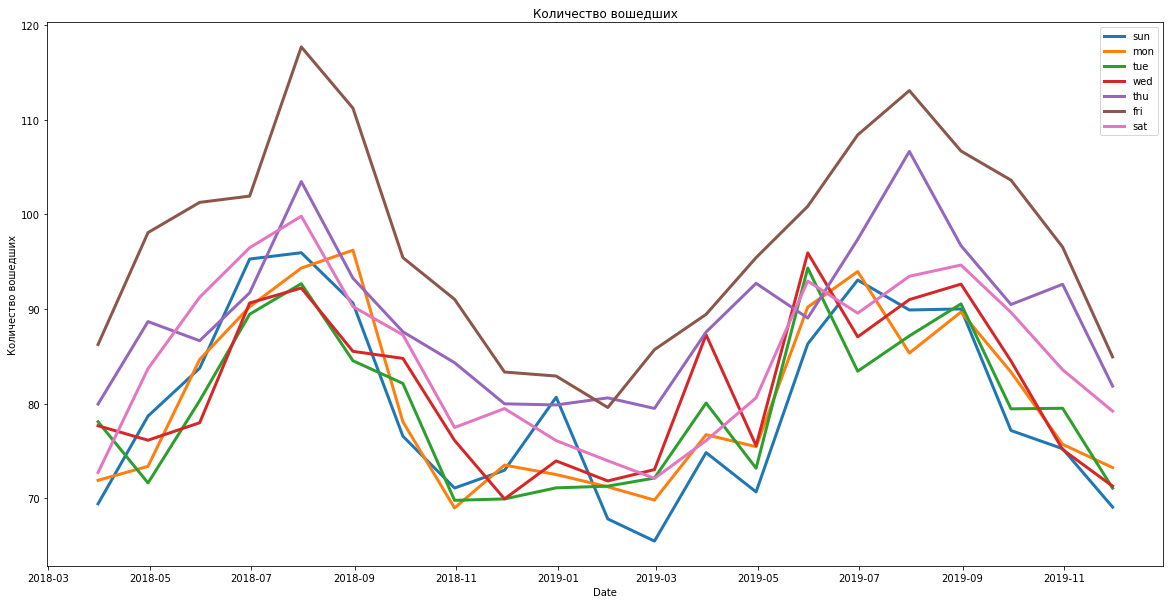

In [13]:
plot_weekday_means(market1_df)

Во втором магазине в топе понедельник, остальные дни недели меняются в лидерстве в завимости от месяца

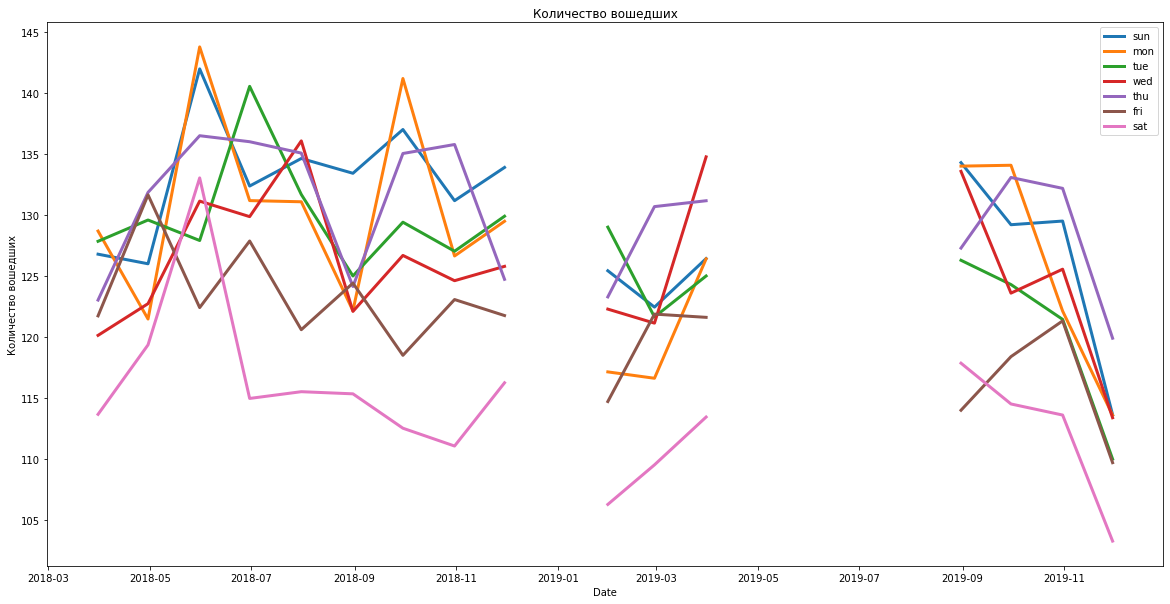

In [14]:
plot_weekday_means(market2_df)

In [15]:
def plot_trend(df1):
    daily_df = df1.resample('D').mean()
    fig, ax = plt.subplots(figsize=(25,10))
    ax.plot(daily_df[traffic_key], marker='.', markersize=2, color='0.6',linestyle='None', label='Daily')# plotting 7-day rolling data
    data_7d_rol = df1[traffic_key].rolling(window=1, center=True).mean()
    ax.plot(data_7d_rol, linewidth=2, label='1-d Rolling Mean')
    data_7d_rol = df1[traffic_key].rolling(window=7, center=True).mean()
    ax.plot(data_7d_rol, color='0.2', linewidth=3, label='7-d Rolling Mean')
    data_30d_rol = df1[traffic_key].rolling(window=30, center=True).mean()
    ax.plot(data_30d_rol, color='r', linewidth=3, label='Trend (30-d Rolling Mean)')
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.legend()
    plt.xlabel('Date'); plt.ylabel(traffic_key); plt.title('Тренд')


Отрисуем 1, 7, 30 дневные скользящие средние. Видно, что месячный тренд меняется периодично.

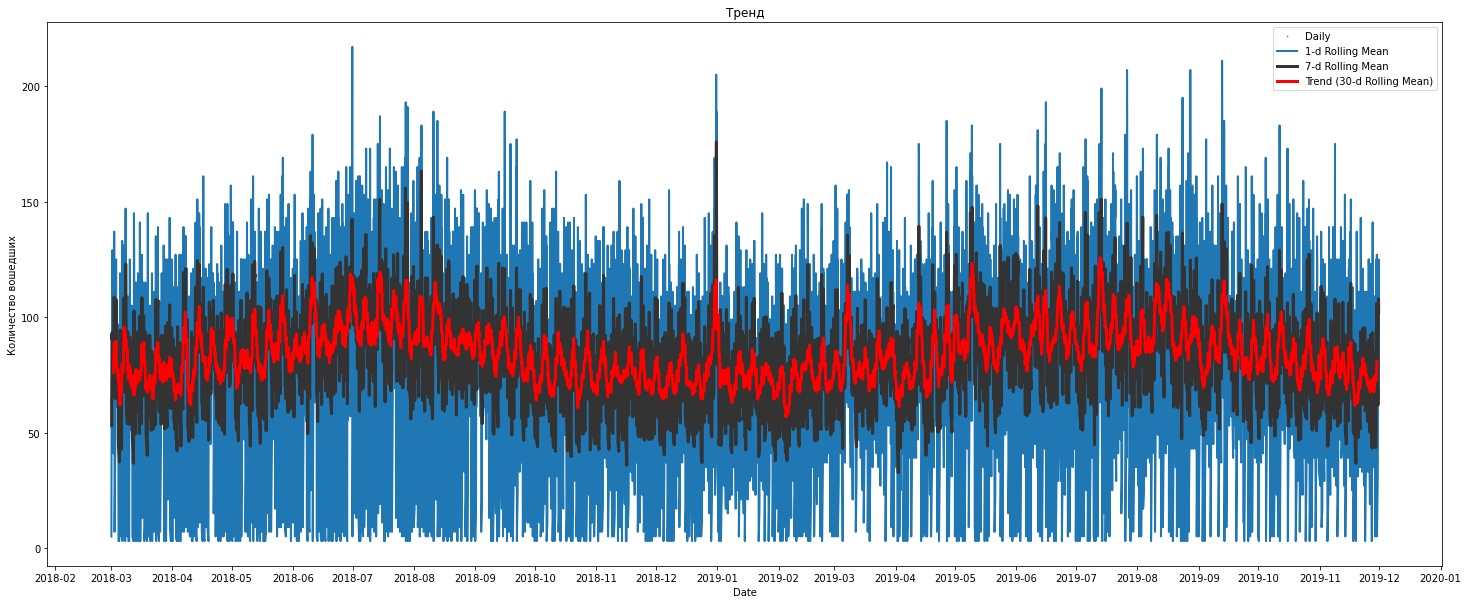

In [16]:
plot_trend(market1_df)

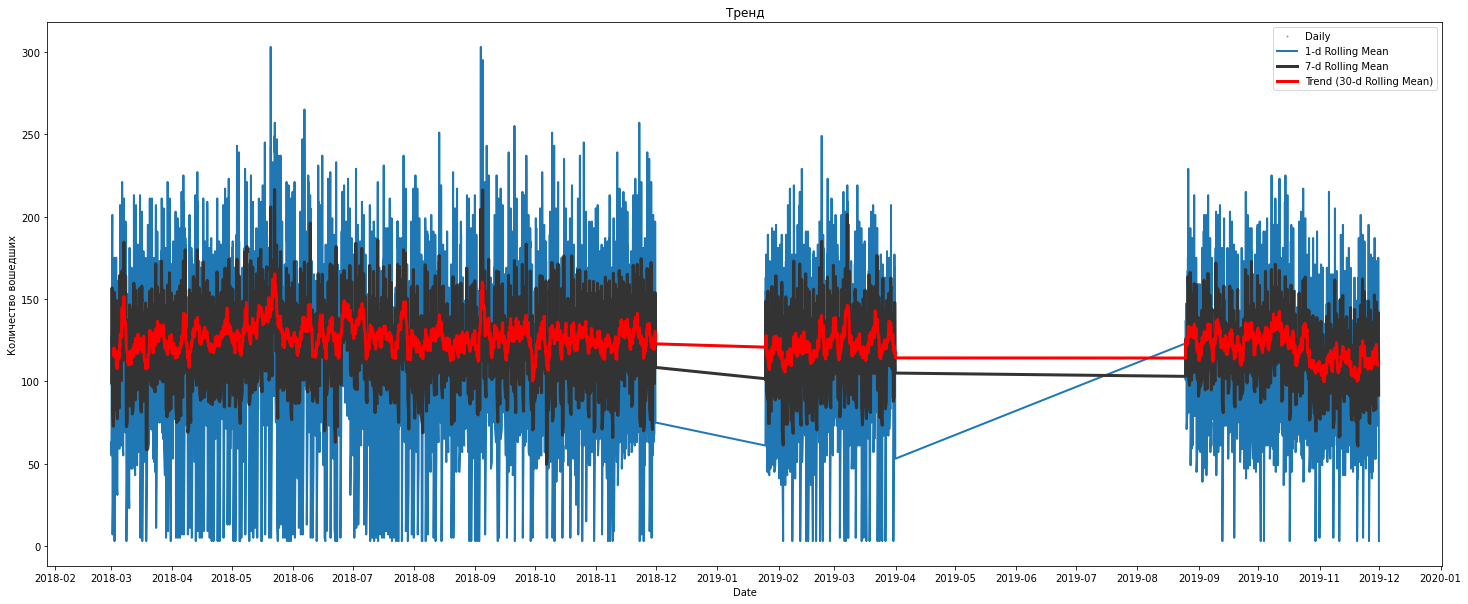

In [17]:
plot_trend(market2_df)

На локальном уровне отчётливо видно периодичность тренда

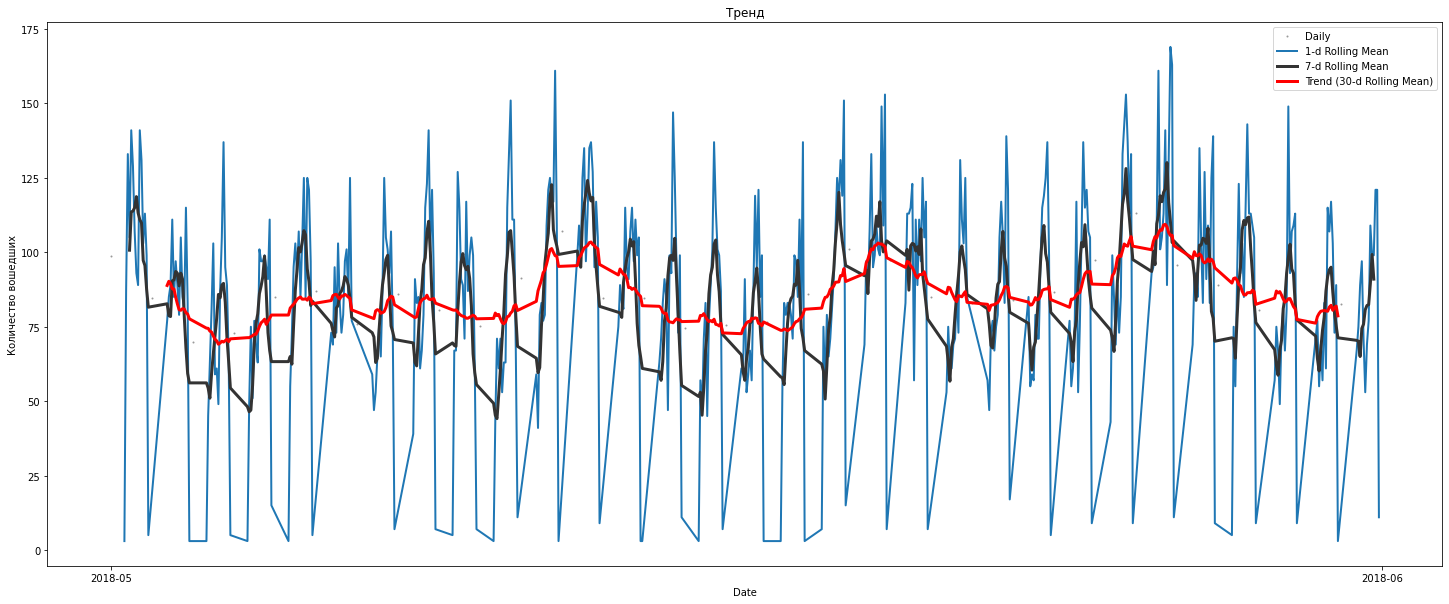

In [18]:
plot_trend(market1_df['2018-05':'2018-05'])

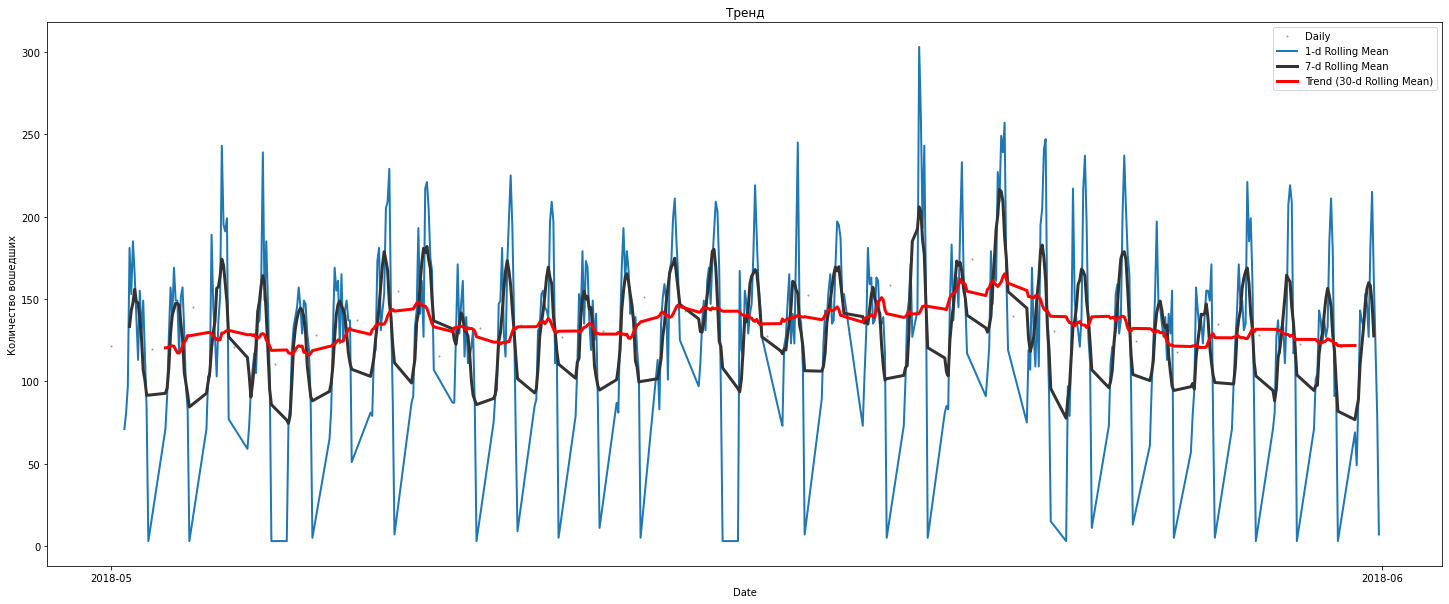

In [19]:
plot_trend(market2_df['2018-05':'2018-05'])

In [20]:
def plot_diff(df1, sl=None):
    df1 = df1.copy()
    df1[traffic_key] = df1[traffic_key].diff()
    if sl is not None:
        df1 = df1[sl]
    plot_trend(df1)

Попробуем сделать дифференцирование первого порядка. Видно, что 7-дневный тренд стал более стабильным.

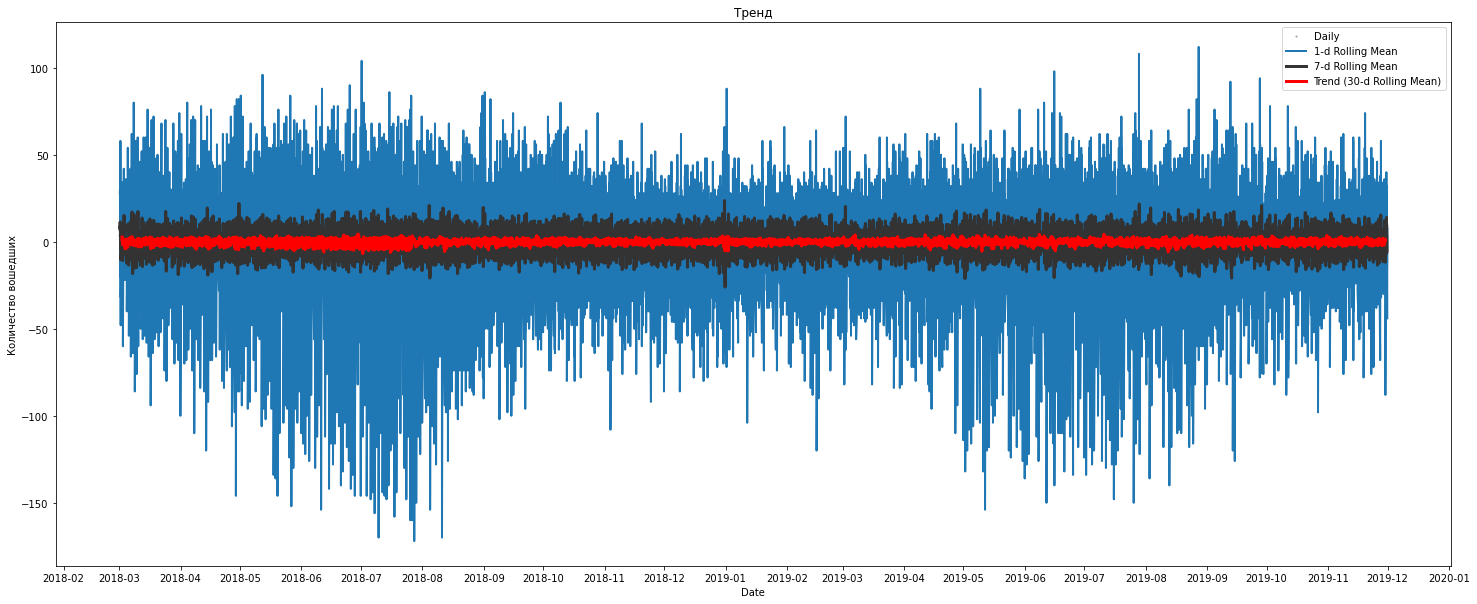

In [21]:
plot_diff(market1_df)

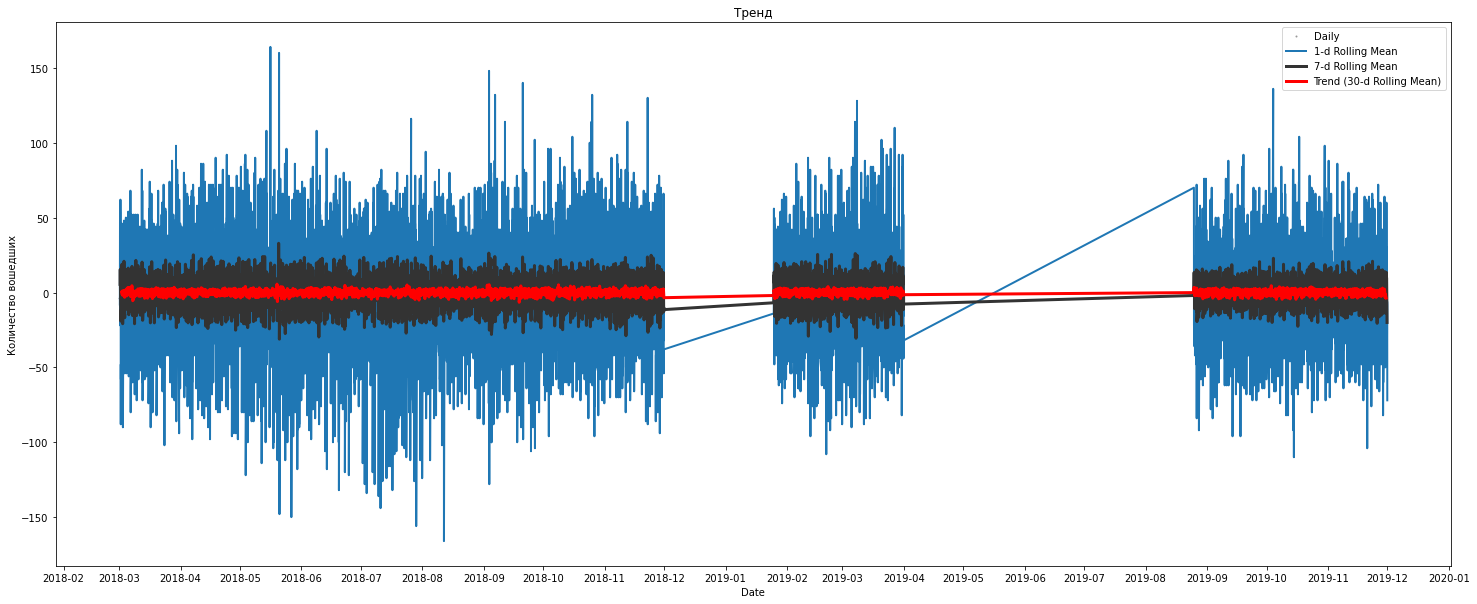

In [22]:
plot_diff(market2_df)

In [23]:
def plot_autocorr(df1, xlim_right, xticks=None, xlim_left=0):
    plt.figure(figsize=(20, 10))
    fig = pd.plotting.autocorrelation_plot(df1[traffic_key])
    fig.set_xlim([xlim_left, xlim_right])
    if xticks is not None:
        plt.xticks(xticks)
    fig.set_ylim([-0.25, 0.75])


Попробуем найти период в данных через автокорреляцию. Видим пики в начале, приблизим график

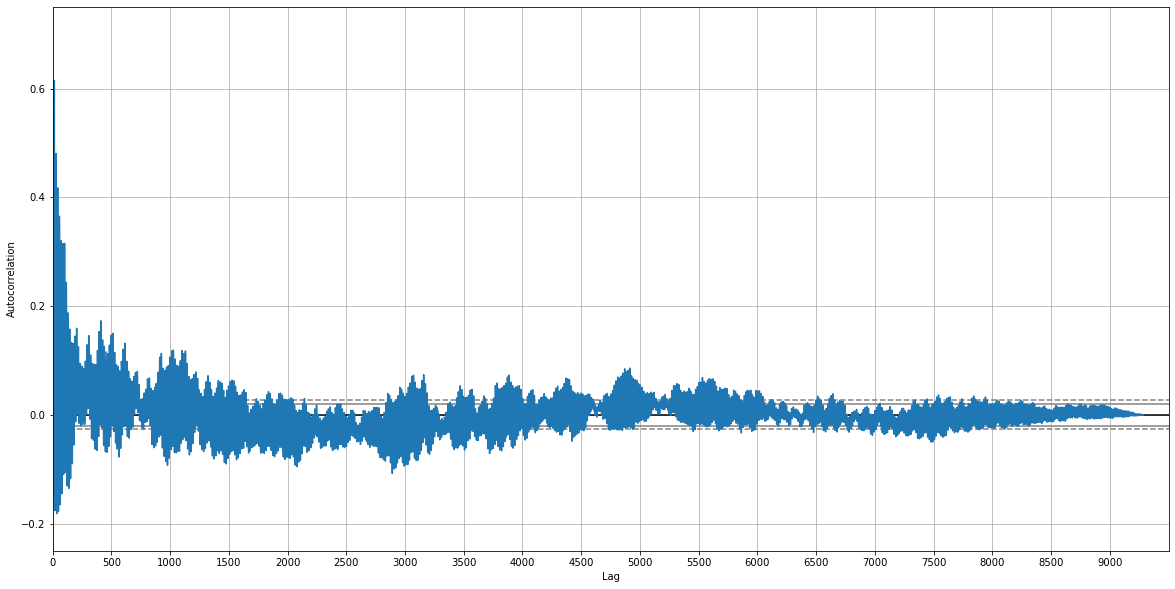

In [24]:
plot_autocorr(market1_df, 9500, np.arange(0, 9500, 500))

Пик в 15 часах. Можно использовать это при прогнозировании

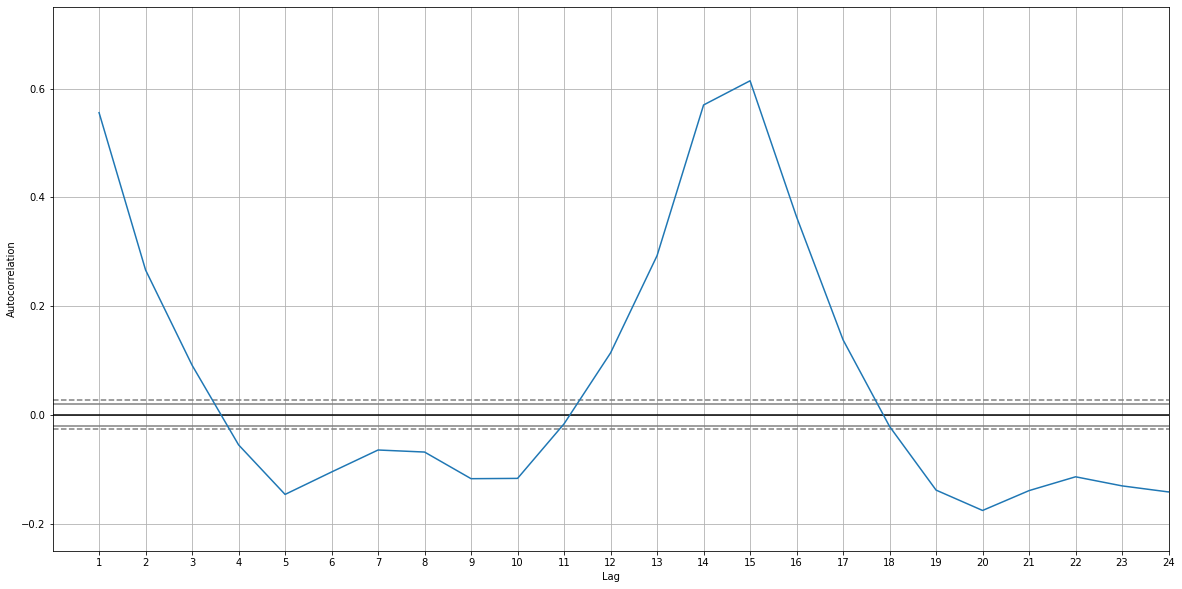

In [25]:
plot_autocorr(market1_df, 24, range(1, 25))

Для прогнозирования можно использовать модель ARIMA, с параметром p=15 для авторегрессии, d=1 для дифференцирования, 0 для скользящего среднего. Также можно попробовать модель Random Forest. В качестве метрики стандартные метрики для задачи регрессии: mean absolute error, mean squared log error, R^2 score